In [29]:
from lib import *

Pipeline = pipeline.Pipeline
RegressionValidator = pipeline.RegressionValidator

DatasetProvider = provider.DatasetProvider
DatasetUploader = provider.DatasetUploader

In [30]:
import warnings

from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

from tqdm._tqdm_notebook import tqdm_notebook
from tqdm._tqdm_notebook import tqdm
tqdm_notebook.pandas()

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [32]:
FETCH_BACKUP = True

## Load train, test sets, idx's

In [33]:
import pickle

def load_pickle(dataset, name):
    dataset.to_pickle(name + '.pkl')

def from_pickle(path):
    with open(path, 'rb') as reader:
        return pickle.load(reader)

In [34]:
dataset_paths = [
    '/home/denissimo/Repo/fs_project/datasets/sample_submission.csv',
    '/home/denissimo/Repo/fs_project/datasets/test.csv',
]

df_provider = DatasetProvider()
df_provider.file_list = dataset_paths
datasets = df_provider.get_dataset()

In [35]:
task_df = {}

task_df['test'] = from_pickle('tmp/task_df_test.pkl')
task_df['train'] = from_pickle('tmp/task_df_train.pkl')
task_df['idx'] = from_pickle('tmp/idx.pkl')

In [36]:
MAP = datasets['test.csv'].merge(
    task_df['idx'][['shop_id', 'item_id', 'id']],
    on=['shop_id', 'item_id'],
    how='left'
)

In [37]:
MAP

,ID,shop_id,item_id,id
0,0,5,5037,485225
1,1,5,5320,364565
2,2,5,5233,486065
3,3,5,5232,566225
4,4,5,5268,1074185
...,...,...,...,...
214195,214195,45,18454,451545
214196,214196,45,16188,1211325
214197,214197,45,15757,435525
214198,214198,45,19648,260805


In [38]:
serieses_month_cnt = from_pickle('tmp/series_cnt.pkl')

In [39]:
baseline_train = from_pickle('tmp/baseline_train_set.pkl')
validation_set = from_pickle('tmp/baseline_validation_set.pkl')
submition_set = from_pickle('tmp/baseline_submit_x.pkl')

In [40]:
for key in baseline_train:
    if not key in ['target', 'lags', 'acf_lags']:
        baseline_train[key].columns = [f'{key}_{agg_type}' for agg_type in baseline_train[key].columns.values]
        validation_set[key].columns = [f'{key}_{agg_type}' for agg_type in validation_set[key].columns.values]
        submition_set[key].columns = [f'{key}_{agg_type}' for agg_type in submition_set[key].columns.values]

In [41]:
full_train = pd.concat(baseline_train.values(), axis=1, join='inner')
full_test = pd.concat(validation_set.values(), axis=1, join='inner')
full_submition = pd.concat(submition_set.values(), axis=1, join='inner')

In [42]:
train_x = full_train.drop(['target'], axis=1).fillna(0)
train_y = full_train.loc[:, ['target']]

test_x = full_test.drop(['target'], axis=1).fillna(0)
test_y = full_test.loc[:, ['target']]

full_submition = full_test.fillna(0)

## Linear model preprocessing

In [43]:
def make_scaled(df_origin):
    def standartize(dataset):
        scaler = StandardScaler()
        try:
            return scaler.fit_transform(dataset.to_numpy())
        except:
            return scaler.fit_transform(dataset)

    df = pd.DataFrame(
        data=standartize(df_origin), 
        index=df_origin.index, 
        columns=df_origin.columns
    )
    return df

In [44]:
train_x = make_scaled(train_x)
test_x = make_scaled(test_x)

## Feature evaluation

In [45]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

if not FETCH_BACKUP:
    evaluation_forest = RandomForestRegressor(n_jobs=-1, max_depth=400)
    evaluation_forest.fit(train_x, train_y)
    with open('tmp/baseline_rfr.pkl', 'wb+') as writer:
        pickle.dump(evaluation_forest, writer)
else:
    evaluation_forest = from_pickle('tmp/baseline_rfr_train_fitted.pkl')

### Primary feature selection

In [46]:
from sklearn.inspection import permutation_importance

if not FETCH_BACKUP:
    perm_importance = permutation_importance(evaluation_forest, train_x, train_y)
else:
    perm_importance = from_pickle('tmp/baseline_importance.pkl')

### Explore permutation feature importance

<AxesSubplot:xlabel='importance', ylabel='feature'>

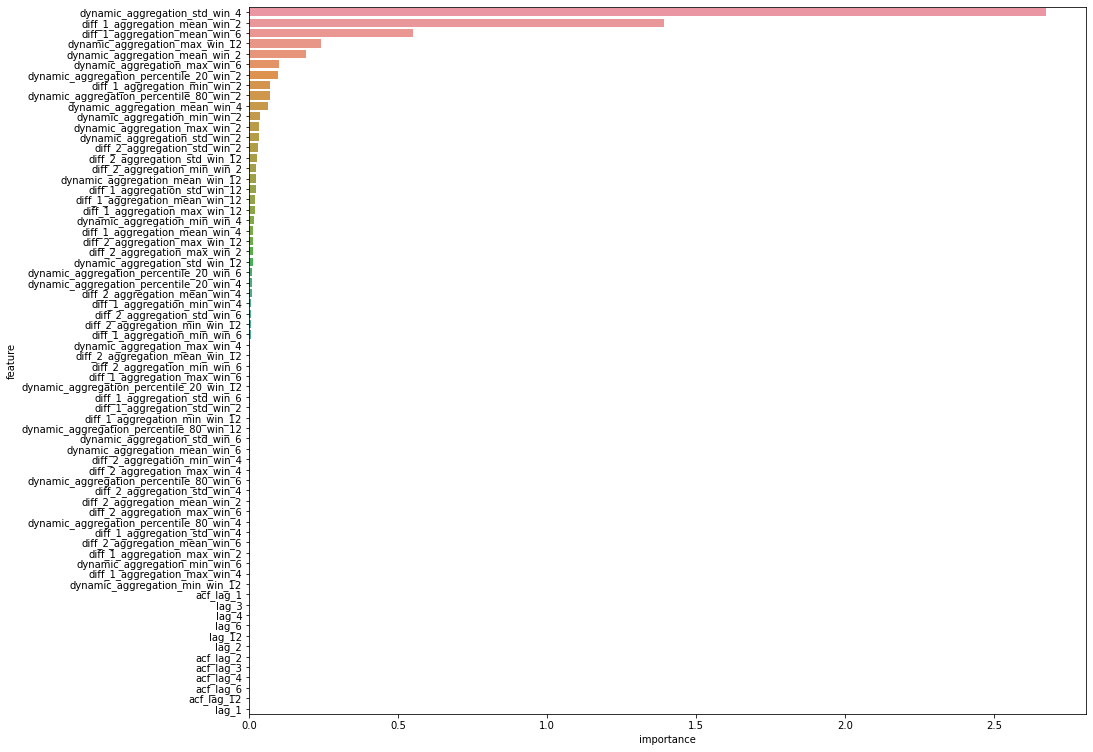

In [47]:
_, axs = plt.subplots(1, 1, figsize=(15, 13))

feature_impotrance_mean = (pd.DataFrame({
        'feature': train_x.columns, 
        'importance': perm_importance['importances_mean']
    })
    .set_index('feature')
    .sort_values('importance', ascending=False))
top_valid_features = feature_impotrance_mean.head(30)
tail_valid_features = feature_impotrance_mean.tail(30)

feature_impotrance_points = pd.DataFrame(perm_importance['importances'])
feature_impotrance_points.index = train_x.columns
feature_impotrance_points = feature_impotrance_points.unstack().reset_index().drop('level_0', axis=1).rename({'level_0': 'permutation', 'level_1': 'feature', 0:'importance'}, axis=1)

sns.barplot(data=feature_impotrance_mean.reset_index(), x='importance', y='feature', ax=axs)

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 80.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


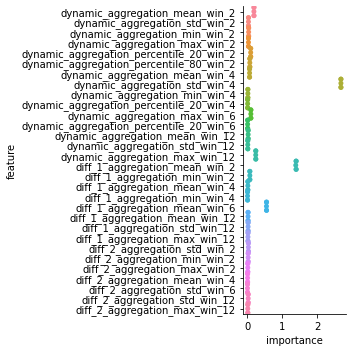

In [48]:
sns.catplot(data=feature_impotrance_points[feature_impotrance_points.feature.isin(top_valid_features.index)], kind='swarm', x='importance', y='feature')

In [49]:
top_train_x = train_x.loc[:, top_valid_features.index.values]
top_test_x = test_x.loc[:, top_valid_features.index.values]

tail_train_x = train_x.loc[:, tail_valid_features.index.values]
tail_test_x = test_x.loc[:, tail_valid_features.index.values]

## Basic models

### We gonna check 3 models (ElasticNet, Random Forest, XGBoost) 

1) Validation model

In [50]:
from sklearn.metrics import mean_squared_error as mse

class Validator:
    def __init__(self, model, **kwargs) -> None:
        self.model = model(**kwargs)
        self._context = {}

    def fit(self, x, y, trained_model=None):
        if trained_model is None:
            self.model.fit(x, y)
        else:
            self.model = trained_model

        return self.model

    def validate(self, x, y):
        
        predictions = self.model.predict(x)
        truth = y

        return mse(predictions, truth), predictions, truth

In [51]:
errors = {}

2) ElasticNet (CRUSHES ALL THE TIME) + ISSUE | Use Ridge instead

In [52]:
# lis = [[], []]

# for alpha_ in range(4, 60):
#     print(alpha_)
#     validator_lin = Validator(Ridge, alpha=10**(alpha_))
    
#     validator_lin.fit(tail_train_x, train_y)
#     err = validator_lin.validate(tail_test_x, test_y)[0]

#     lis[0].append(alpha_)
#     lis[1].append(err)

# sns.scatterplot(*lis)

In [53]:
lin_validator = Validator(Ridge, alpha=1e7)

lin_validator.fit(train_x, train_y)
errors['ridge'] = lin_validator.validate(test_x, test_y)
errors['ridge'][0]

with open('tmp/ridge_error.pkl', 'wb+') as writer:
        pickle.dump(errors['ridge'], writer)


3.1020921763666367

3) Random Forest

In [54]:
lin_validator = Validator(RandomForestRegressor)

lin_validator.fit(train_x, train_y, trained_model=evaluation_forest)
errors['rfr'] = lin_validator.validate(test_x, test_y)
errors['rfr'][0]

52.12551021129662

Checking top and head predictors 

## Submission estimation

My bad, I've broken my lag and acf features

In [55]:
baseline_train['lags'].isna().sum().sum()

2535462